In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os 
import sys 
import re
from tqdm import tqdm
from joblib import Parallel, delayed

In [49]:
normal_dataset = torch.load('./save_normal_metric_check/normal_dataset.pt')

normal_data = normal_dataset.getAllData()

items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
# obs_train, obs_test, Y_train, Y_test = normal_dataset.getTrainTestSplit(train_size=num_users*num_pairs_per_user)


In [75]:
# Oracle prediction (just for verification) original version
delta_s = []
pred_ys = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)
oracle_pred = np.mean(pred_ys == true_y)
print('Oracle prediciton:', np.mean(pred_ys == true_y))

Oracle prediciton: 0.7943


In [51]:
grid_search_fileNames = os.listdir('./save_normal_metric_check/')
grid_search_filePaths = [os.path.join('./save_normal_metric_check/',i) for i in grid_search_fileNames if i.find('normal_dataset') == -1]

In [52]:
res_list = [torch.load(filePath) for filePath in tqdm(grid_search_filePaths)]

100%|██████████| 27/27 [01:09<00:00,  2.56s/it]


In [54]:
sample_size = []
final_test_accu = []
final_relative_metric_error = []
final_relative_ideal_point_error = []
final_relative_ideal_point_error_original = []
final_learner = []
for i in res_list:
    sample_size.append(i['args']['num_pairs_per_user'])
    final_test_accu.append(i['train_stats']['test_accu_record'][-1])
    final_relative_metric_error.append(i['train_stats']['relative_metric_error_record'][-1])
    final_relative_ideal_point_error.append(i['train_stats']['relative_ideal_point_error_record'][-1])
    final_relative_ideal_point_error_original.append(i['train_stats']['relative_ideal_point_error_original_record'][-1])
    final_learner.append(i['learner'])

In [55]:
sample_size,final_test_accu,final_relative_metric_error,final_relative_ideal_point_error, final_learner = list(zip(*sorted(zip(sample_size,final_test_accu,final_relative_metric_error,final_relative_ideal_point_error,final_learner))))

Text(0.5, 1.0, 'Simulated Dataset Preference Prediction Accuracy')

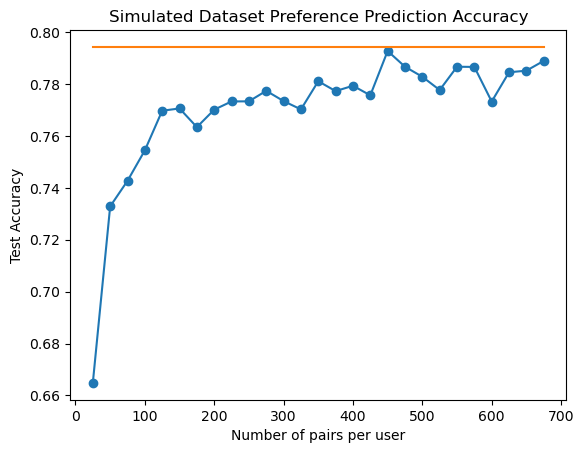

In [76]:
fig,ax = plt.subplots()
ax.plot(sample_size,final_test_accu, '-o')
ax.plot(sample_size,[oracle_pred]*len(sample_size))
ax.set_xlabel('Number of pairs per user')
ax.set_ylabel('Test Accuracy')
ax.set_title('Simulated Dataset Preference Prediction Accuracy')

Text(0.5, 1.0, 'Simulated Dataset relative metric error')

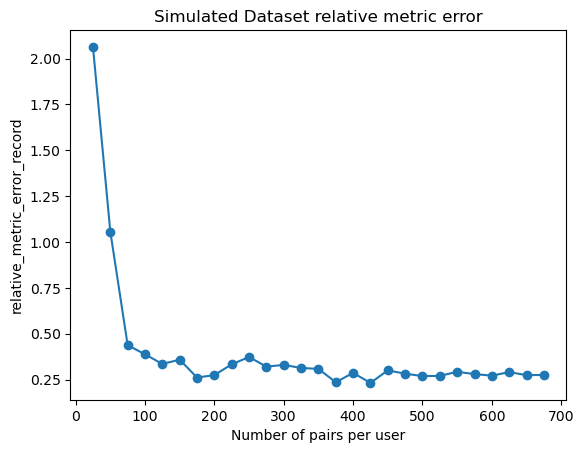

In [57]:
fig,ax = plt.subplots()
ax.plot(sample_size,final_relative_metric_error, '-o')
ax.set_xlabel('Number of pairs per user')
ax.set_ylabel('relative_metric_error_record')
ax.set_title('Simulated Dataset relative metric error')

Text(0.5, 1.0, 'Simulated Dataset relative ideal point error')

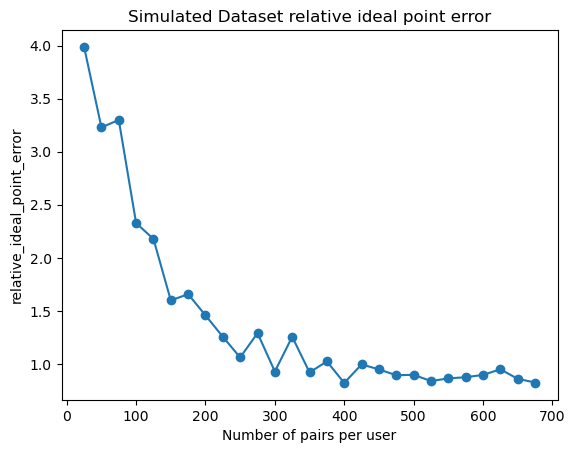

In [58]:
fig,ax = plt.subplots()
ax.plot(sample_size,final_relative_ideal_point_error, '-o')
ax.set_xlabel('Number of pairs per user')
ax.set_ylabel('relative_ideal_point_error')
ax.set_title('Simulated Dataset relative ideal point error')

Text(0.5, 1.0, 'Simulated Dataset relative ideal point error (original)')

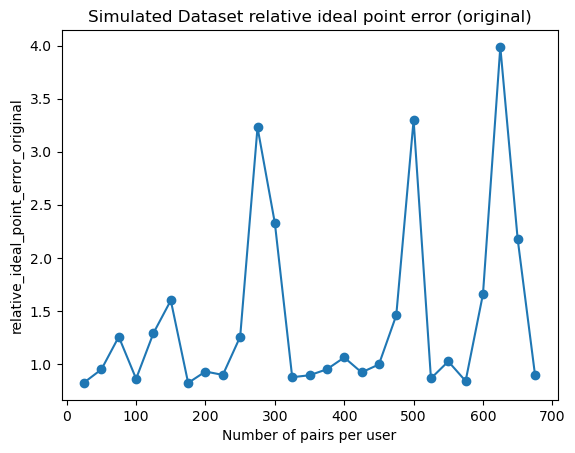

In [60]:
fig,ax = plt.subplots()
ax.plot(sample_size,final_relative_ideal_point_error_original, '-o')
ax.set_xlabel('Number of pairs per user')
ax.set_ylabel('relative_ideal_point_error_original')
ax.set_title('Simulated Dataset relative ideal point error (original)')

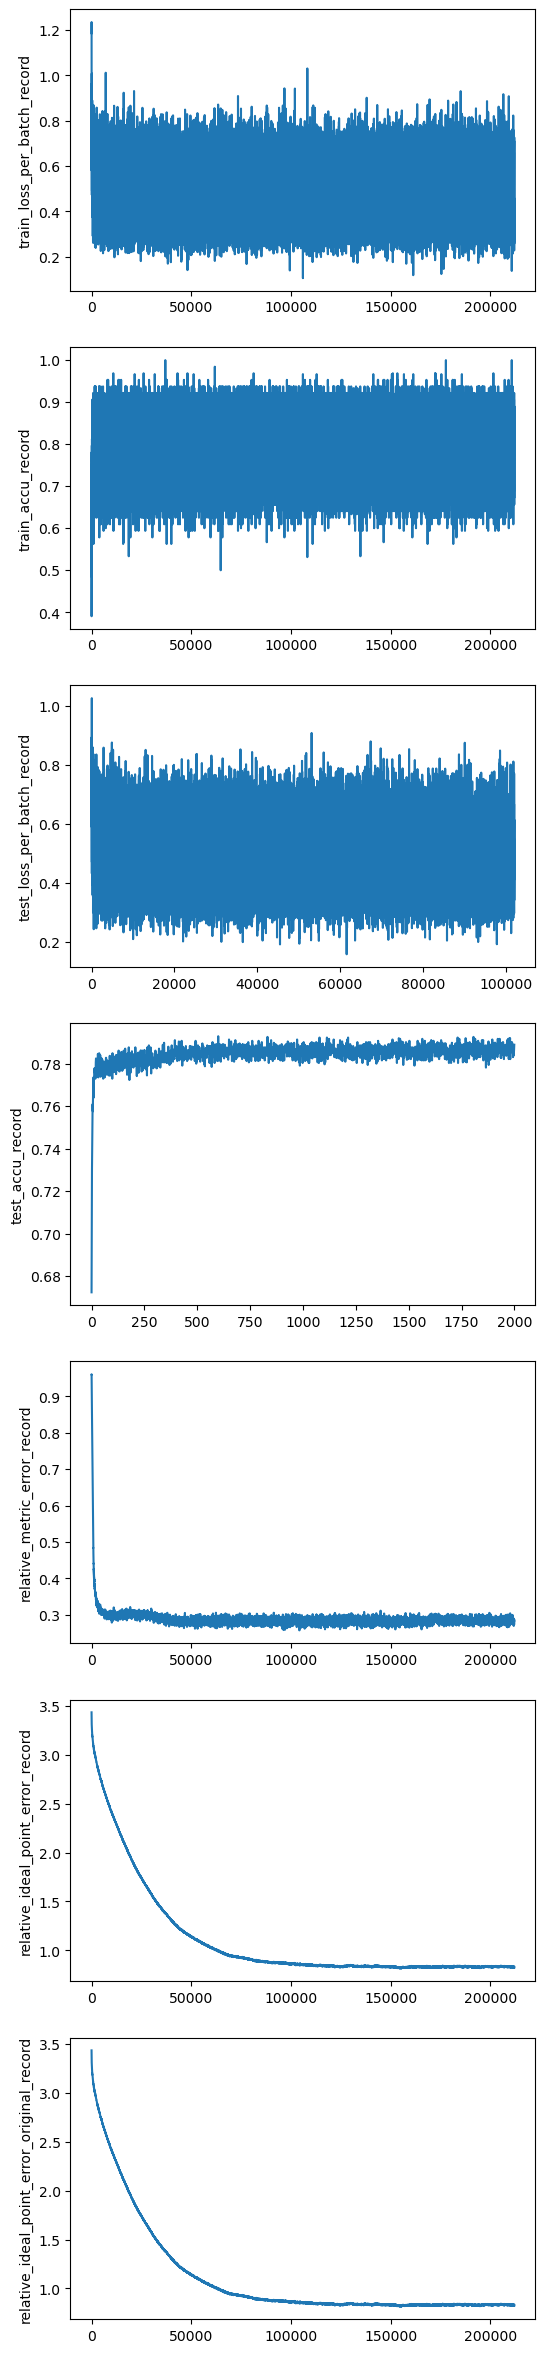

In [74]:
fig,ax = plt.subplots(7,1,figsize=(6,30))
ax_flatten = ax.flatten()
for idx,key in enumerate(res_list[0]['train_stats']):
    ax_flatten[idx].plot(res_list[0]['train_stats'][key])
    ax_flatten[idx].set_ylabel(key)

# Metric singular value check

In [46]:

pred_M_list = []
pred_U_list = []
singular_list = []

for i in final_learner:
    pred_L = i.model.layers.weight.detach().numpy()
    pred_M_list.append(pred_L.T @ pred_L)
    pred_U_list.append(i.us.detach().numpy())
    U, S, Vh = np.linalg.svd(pred_L.T @ pred_L)
    singular_list.append(S)

Text(0.5, 1.0, 'The singular values of $\\hat{M}$ with different num_pairs_per_user (Normal dataset)')

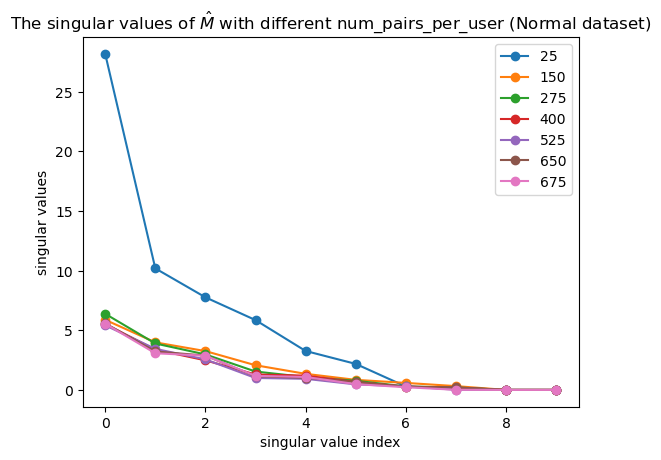

In [61]:
fig,ax = plt.subplots()

for i in [0,5,10,15,20,25,-1]:
    ax.plot(np.array(singular_list)[i,:],'-o',label=sample_size[i])
ax.legend()

ax.set_xlabel('singular value index')
ax.set_ylabel('singular values')
ax.set_title('The singular values of $\hat{M}$ with different num_pairs_per_user (Normal dataset)')